In [3]:
!pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.7/dist-packages (2.4.3)


In [35]:
import csv
import nltk
import pandas as pd
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

In [37]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [48]:
class SentimentNLP():
  def __init__(self, 
               sequence_length=2000, 
               embed_dim=128, 
               batch_size=32, 
               epochs=200,
               num_words=1000,
               oov_token="<UNK>",
               pad_type="post",
               trunc_type="post"):
    


    self.sequence_length = sequence_length
    self.embed_dim = embed_dim
    self.batch_size = batch_size
    self.epochs = epochs

    self.num_words = num_words
    self.oov_token = oov_token
    self.pad_type = pad_type
    self.trunc_type = trunc_type


    print("Loading Data.......")
    df = self.load_data()


    print("Formatting Data......")
    sentences = df["sentences"]

    sentences = self.lower_case(sentences)

    sentences_sequences, word_index, maxlen, sentences_padded = self.tokenize_data(sentences)


    print("Data Stats......")
    print("Word index:\n", word_index)
    print("\nTraining sequences:\n", sentences_sequences)
    print("\nPadded training sequences:\n", sentences_padded)

    print("Splitting Data....")
    X_train, X_test, y_train, y_test = self.get_data(sentences_padded)

    print(f"X_train:\n {X_train}")
    print(f"X_test:\n {X_test}")
    print(f"y_train:\n {y_train}")
    print(f"y_test:\n {y_test}")
    


    print("Building Model.......")
    model = self.build_model(X_train)
    print("Built Model,")


    print("Training Model.......")
    history = self.train_dataset(model, X_train, y_train, X_test, y_test)

    print("Model Trained.")

    print("Saving Plots.........")
    self.plot_acc(history)
    self.plot_loss(history)


  def load_data(self):
    df = pd.read_csv("data.csv")
    return df

  def lower_case(self, text_list):
    lower_phrases = []
    for phrase in text_list:
      lower_phrases.append(phrase.lower())
    
    return lower_phrases
  
  def tokenize_data(self, text_list, num_words=1000, oov_token="<UNK>", pad_type="post", trunc_type="post"):
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    tokenizer.fit_on_texts(text_list)
    word_index = tokenizer.word_index
    train_sequences = tokenizer.texts_to_sequences(text_list)
    
    print("here")
    
    with open('tokenizer.pickle', 'wb') as f:
      pickle.dump(tokenizer, f)

    maxlen = max([len(x) for x in train_sequences])
    
    train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)



    return train_sequences, word_index, maxlen, train_padded

  
  def get_data(self, train_data):
    df = self.load_data()
    train_classes = pd.get_dummies(df["class_names"])
    train_classes = train_classes.iloc[:, :-1]

                                   
    X, y = train_data, train_classes
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)

    return X_train, X_test, y_train, y_test

  def build_model(self, X, sequence_length=2000, embed_dim=128):
    model = Sequential()
    model.add(Embedding(sequence_length, embed_dim, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.4))
    model.add(Bidirectional(CuDNNLSTM(196)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation="sigmoid"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model 

  def train_dataset(self, model, X_train, y_train, X_test, y_test, batch_size=32):      
      history = model.fit(X_train, y_train, epochs=37, batch_size=batch_size, verbose=2)

      model.save("sentiment_analysis_.h5")

      score, acc = model.evaluate(X_test, y_test, verbose=2, batch_size=batch_size)

      print("score: %.2f" % (score))
      print("acc: %.2f" % (acc))

      return history

  def plot_acc(self, history):
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.savefig('graphs/acc.png')


  def plot_loss(self, history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.savefig('graphs/loss.png')

Loading Data.......
Formatting Data......
here
Data Stats......
Word index:
 {'<UNK>': 1, 'you': 2, 'i': 3, 'to': 4, 'the': 5, 'a': 6, 'it': 7, 'is': 8, 'that': 9, 'do': 10, 'what': 11, 'have': 12, 'for': 13, 'and': 14, 'of': 15, 'are': 16, 'in': 17, 'my': 18, 'your': 19, 'can': 20, 'be': 21, 'me': 22, 'we': 23, 'on': 24, "i'm": 25, 'this': 26, 'like': 27, 'with': 28, 'will': 29, 'how': 30, 'name': 31, 'know': 32, 'need': 33, 'would': 34, "don't": 35, 'about': 36, 'but': 37, 'so': 38, 'get': 39, 'was': 40, 'at': 41, 'going': 42, "that's": 43, 'there': 44, 'yes': 45, 'go': 46, 'want': 47, 'think': 48, 'good': 49, 'not': 50, 'no': 51, 'just': 52, "it's": 53, 'if': 54, 'did': 55, 'all': 56, 'they': 57, 'really': 58, 'out': 59, 'one': 60, 'help': 61, 'he': 62, 'right': 63, "i'll": 64, 'why': 65, 'too': 66, 'time': 67, 'should': 68, 'an': 69, 'take': 70, 'sure': 71, 'here': 72, 'make': 73, 'some': 74, 'up': 75, 'well': 76, 'see': 77, 'when': 78, 'where': 79, 'or': 80, 'our': 81, 'great': 82

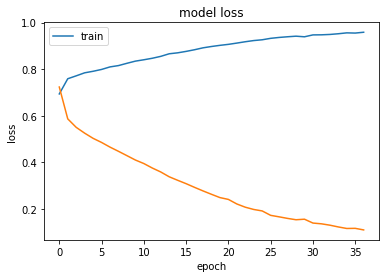

In [49]:
sentimentNLP = SentimentNLP()